<a href="https://colab.research.google.com/github/nalsadi/DeepQReg/blob/main/Deep_Q_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Registration

###Naseem Alsadi

####Deep Reinforcement Learning Framework for Image Registration 

###### Built on top of Voxelmorph framework (Temporary) 


---

# Preamble
## Setup of environment

In [1]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 

     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 92kB 4.5MB/s 


We'll start with some common imports  

In [2]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [22]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

### Load MNIST Data


In [4]:
# You should most often have this import together with all other imports at the top, 
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist
!pip install neurite
import neurite as ne # For visualizing the data, could also use matlib plt

In [24]:
# load MNIST data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

shape of x_train: (5421, 28, 28), y_train: (5421,)


**Side note**: separating your data in *only* train/test **often leads to problems**   
You wouldn't want to iteratively (A) build a model, (B) train on training data, and (C) test on test data  
Doing so will **overfit to you test set** (because you will have adapted your algorithm to your test data  

We will split the 'training' into 'train/validate' data, and keep the test set for later  
And will only look at the test data at the very end (once we're ready to submit the paper!)  

In [25]:
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

### Visualize Data

Believeing we are done loading, it's always great to visualize the data  
Here, we use some tools from a package called `neuron`, which uses matplotlib  
You could use matplotlib as well directly, but it would just be a bit messier  
and here we want to illustrate the main concepts.  

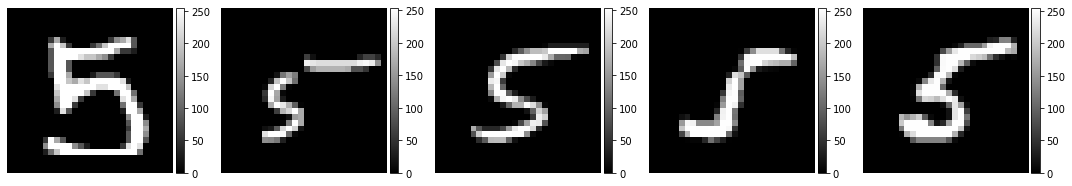

In [26]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Looks good!  

However, luckily we included a **colorbar**, which shows us that the data is in [0, 255].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
Let's fix this. 

In general, you should always plot your data with colorbars, which helps you catch issues before training  

In [27]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


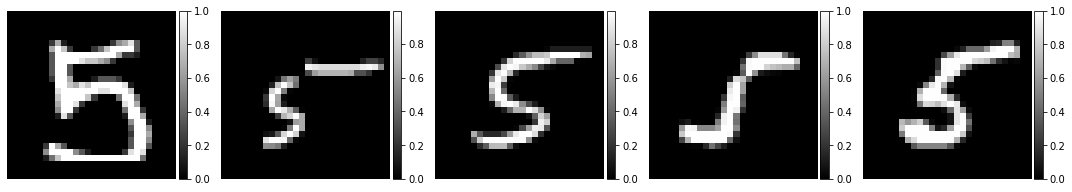

In [28]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

One last change. Later on, we'll see that some of the most popular models like to have inputs that are sized as multiples of 2^N for N being the number of layers. Here, we force our images to be size 32 (2x 2^4).

In [29]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


# U-Net Architecture

Convolutional Networks for Image Segmentation


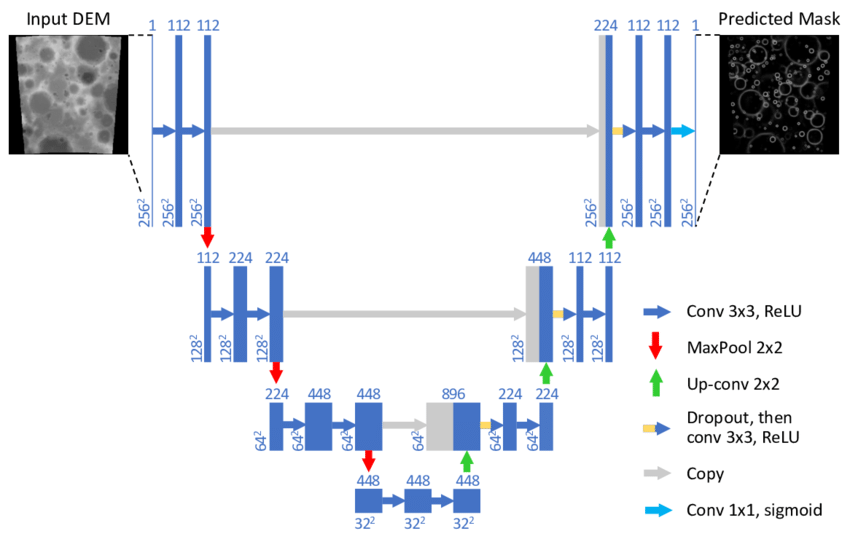

In [56]:
"""
tensorflow/keras networks for voxelmorph

If you use this code, please cite one of the voxelmorph papers:
https://github.com/voxelmorph/voxelmorph/blob/master/citations.bib

License: GPLv3
"""

# internal python imports
from collections.abc import Iterable

# third party imports
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.initializers as KI

# local imports
import neurite as ne
from .. import default_unet_features
from . import layers
from . import synthseg
# TODO: change full module imports as opposed to specific function imports
from .modelio import LoadableModel, store_config_args
from .utils import value_at_location, point_spatial_transformer


# make ModelCheckpointParallel directly available from vxm
ModelCheckpointParallel = ne.callbacks.ModelCheckpointParallel


class VxmDense(LoadableModel):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    @store_config_args
    def __init__(self,
            inshape,
            nb_unet_features=None,
            nb_unet_levels=None,
            unet_feat_mult=1,
            nb_unet_conv_per_level=1,
            int_steps=7,
            int_downsize=2,
            bidir=False,
            use_probs=False,
            src_feats=1,
            trg_feats=1,
            unet_half_res=False,
            input_model=None,
            name='vxm_dense'):
        """ 
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_unet_features is an integer. Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_unet_features is an integer. Default is 1.
            nb_unet_conv_per_level: Number of convolutions per unet level. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration. The flow field
                is not downsampled when this value is 1.
            bidir: Enable bidirectional cost function. Default is False.
            use_probs: Use probabilities in flow field. Default is False.
            src_feats: Number of source image features. Default is 1.
            trg_feats: Number of target image features. Default is 1.
            unet_half_res: Skip the last unet decoder upsampling. Requires that int_downsize=2. Default is False.
            input_model: Model to replace default input layer before concatenation. Default is None.
            name: Model name - also used as layer name prefix. Default is 'vxm_dense'.
        """

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        if input_model is None:
            # configure default input layers if an input model is not provided
            source = tf.keras.Input(shape=(*inshape, src_feats), name='%s_source_input' % name)
            target = tf.keras.Input(shape=(*inshape, trg_feats), name='%s_target_input' % name)
            input_model = tf.keras.Model(inputs=[source, target], outputs=[source, target])
        else:
            source, target = input_model.outputs[:2]

        # build core unet model and grab inputs
        unet_model = Unet(
            input_model=input_model,
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
            name='%s_unet' % name
        )

        # transform unet output into a flow field
        Conv = getattr(KL, 'Conv%dD' % ndims)
        flow_mean = Conv(ndims, kernel_size=3, padding='same',
                    kernel_initializer=KI.RandomNormal(mean=0.0, stddev=1e-5), name='%s_flow' % name)(unet_model.output)

        # optionally include probabilities
        if use_probs:
            # initialize the velocity variance very low, to start stable
            flow_logsigma = Conv(ndims, kernel_size=3, padding='same',
                            kernel_initializer=KI.RandomNormal(mean=0.0, stddev=1e-10),
                            bias_initializer=KI.Constant(value=-10),
                            name='%s_log_sigma' % name)(unet_model.output)
            flow_params = KL.concatenate([flow_mean, flow_logsigma], name='%s_prob_concat' % name)
            flow = ne.layers.SampleNormalLogVar(name='%s_z_sample' % name)([flow_mean, flow_logsigma])
        else:
            flow_params = flow_mean
            flow = flow_mean

        if not unet_half_res:
            # optionally resize for integration
            if int_steps > 0 and int_downsize > 1:
                flow = layers.RescaleTransform(1 / int_downsize, name='%s_flow_resize' % name)(flow)

        preint_flow = flow

        # optionally negate flow for bidirectional model
        pos_flow = flow
        if bidir:
            neg_flow = ne.layers.Negate(name='%s_neg_flow' % name)(flow)

        # integrate to produce diffeomorphic warp (i.e. treat flow as a stationary velocity field)
        if int_steps > 0:
            pos_flow = layers.VecInt(method='ss', name='%s_flow_int' % name, int_steps=int_steps)(pos_flow)
            if bidir:
                neg_flow = layers.VecInt(method='ss', name='%s_neg_flow_int' % name, int_steps=int_steps)(neg_flow)

            # resize to final resolution
            if int_downsize > 1:
                pos_flow = layers.RescaleTransform(int_downsize, name='%s_diffflow' % name)(pos_flow)
                if bidir:
                    neg_flow = layers.RescaleTransform(int_downsize, name='%s_neg_diffflow' % name)(neg_flow)

        # warp image with flow field
        y_source = layers.SpatialTransformer(interp_method='linear', indexing='ij', name='%s_transformer' % name)([source, pos_flow])
        if bidir:
            y_target = layers.SpatialTransformer(interp_method='linear', indexing='ij', name='%s_neg_transformer' % name)([target, neg_flow])

        # initialize the keras model
        outputs = [y_source, y_target] if bidir else [y_source]

        if use_probs:
            # compute loss on flow probabilities
            outputs += [flow_params]
        else:
            # compute smoothness loss on pre-integrated warp
            outputs += [preint_flow]

        super().__init__(name=name, inputs=input_model.inputs, outputs=outputs)

        # cache pointers to layers and tensors for future reference
        self.references = LoadableModel.ReferenceContainer()
        self.references.unet_model = unet_model
        self.references.y_source = y_source
        self.references.y_target = y_target if bidir else None
        self.references.pos_flow = pos_flow
        self.references.neg_flow = neg_flow if bidir else None

    def get_registration_model(self):
        """
        Returns a reconfigured model to predict only the final transform.
        """
        return tf.keras.Model(self.inputs, self.references.pos_flow)

    def register(self, src, trg):
        """
        Predicts the transform from src to trg tensors.
        """
        return self.get_registration_model().predict([src, trg])

    def apply_transform(self, src, trg, img, interp_method='linear'):
        """
        Predicts the transform from src to trg and applies it to the img tensor.
        """
        warp_model = self.get_registration_model()
        img_input = tf.keras.Input(shape=img.shape[1:])
        y_img = layers.SpatialTransformer(interp_method=interp_method)([img_input, warp_model.output])
        return tf.keras.Model(warp_model.inputs + [img_input], y_img).predict([src, trg, img])


###############################################################################
# Utility/Core Networks
###############################################################################

class Transform(tf.keras.Model):
    """
    Simple transform model to apply dense or affine transforms.
    """

    def __init__(self,
        inshape,
        affine=False,
        interp_method='linear',
        rescale=None,
        fill_value=None,
        nb_feats=1):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            affine: Enable affine transform. Default is False.
            interp_method: Interpolation method. Can be 'linear' or 'nearest'. Default is 'linear'.
            rescale: Transform rescale factor. Default is None.
            fill_value: Fill value for SpatialTransformer. Default is None.
            nb_feats: Number of source image features. Default is 1.
        """

        # configure inputs
        ndims = len(inshape)
        scan_input = tf.keras.Input((*inshape, nb_feats), name='scan_input')

        if affine:
            trf_input = tf.keras.Input((ndims * (ndims + 1),), name='trf_input')
        else:
            trf_shape = inshape if rescale is None else [int(d / rescale) for d in inshape]
            trf_input = tf.keras.Input((*trf_shape, ndims), name='trf_input')

        trf_scaled = trf_input if rescale is None else layers.RescaleTransform(rescale)(trf_input)

        # transform and initialize the keras model
        trf_layer = layers.SpatialTransformer(interp_method=interp_method,
                                              name='transformer',
                                              fill_value=fill_value)
        y_source = trf_layer([scan_input, trf_scaled])
        super().__init__(inputs=[scan_input, trf_input], outputs=y_source)


class Unet(tf.keras.Model):
    """
    A unet architecture that builds off either an input keras model or input shape. Layer features can be
    specified directly as a list of encoder and decoder features or as a single integer along with a number
    of unet levels. The default network features per layer (when no options are specified) are:

        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]

    This network specifically does not subclass LoadableModel because it's meant to be a core,
    internal model for more complex networks, and is not meant to be saved/loaded independently.
    """

    def __init__(self,
                 inshape=None,
                 input_model=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 do_res=False,
                 half_res=False,
                 name='unet'):
        """
        Parameters:
            inshape: Optional input tensor shape (including features). e.g. (192, 192, 192, 2).
            input_model: Optional input model that feeds directly into the unet before concatenation.
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer. Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. Default is 1.
            nb_conv_per_level: Number of convolutions per unet level. Default is 1.
            half_res: Skip the last decoder upsampling. Default is False.
            name: Model name - also used as layer name prefix. Default is 'unet'.
        """

        # have the option of specifying input shape or input model
        if input_model is None:
            if inshape is None:
                raise ValueError('inshape must be supplied if input_model is None')
            unet_input = KL.Input(shape=inshape, name='%s_input' % name)
            model_inputs = [unet_input]
        else:
            unet_input = KL.concatenate(input_model.outputs, name='%s_input_concat' % name)
            model_inputs = input_model.inputs

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        ndims = len(unet_input.get_shape()) - 2
        assert ndims in (1, 2, 3), 'ndims should be one of 1, 2, or 3. found: %d' % ndims
        MaxPooling = getattr(KL, 'MaxPooling%dD' % ndims)

        # extract any surplus (full resolution) decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool]*nb_levels

        # configure encoder (down-sampling path)
        enc_layers = []
        last = unet_input
        for level in range(nb_levels - 1):
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                layer_name = '%s_enc_conv_%d_%d' % (name, level, conv)
                last = _conv_block(last, nf, name=layer_name, do_res=do_res)
            enc_layers.append(last)
            
            # temporarily use maxpool since downsampling doesn't exist in keras
            last = MaxPooling(max_pool[level], name='%s_enc_pooling_%d' % (name, level))(last)

        # configure decoder (up-sampling path)
        for level in range(nb_levels - 1):
            real_level = nb_levels - level - 2
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                layer_name = '%s_dec_conv_%d_%d' % (name, real_level, conv)
                last = _conv_block(last, nf, name=layer_name, do_res=do_res)
            if not half_res or level < (nb_levels - 2):
                layer_name = '%s_dec_upsample_%d' % (name, real_level)
                last = _upsample_block(last, enc_layers.pop(), factor=max_pool[real_level], name=layer_name)

        # now we take care of any remaining convolutions
        for num, nf in enumerate(final_convs):
            layer_name = '%s_dec_final_conv_%d' % (name, num)
            last = _conv_block(last, nf, name=layer_name)

        super().__init__(inputs=model_inputs, outputs=last, name=name)


###############################################################################
# Private functions
###############################################################################

def _conv_block(x, nfeat, strides=1, name=None, do_res=False):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """
    ndims = len(x.get_shape()) - 2
    assert ndims in (1, 2, 3), 'ndims should be one of 1, 2, or 3. found: %d' % ndims
    Conv = getattr(KL, 'Conv%dD' % ndims)

    convolved = Conv(nfeat, kernel_size=3, padding='same', kernel_initializer='he_normal', strides=strides, name=name)(x)
    name = name + '_activation' if name else None

    if do_res:
        # assert nfeat == x.get_shape()[-1], 'for residual number of features should be constant'
        add_layer = x
        print('note: this is a weird thing to do, since its not really residual training anymore')
        if nfeat != x.get_shape().as_list()[-1]:
            add_layer = Conv(nfeat, kernel_size=3, padding='same', kernel_initializer='he_normal', name='resfix_'+name)(x)
        convolved = KL.Lambda(lambda x: x[0] + x[1])([add_layer, convolved])

    return KL.LeakyReLU(0.2, name=name)(convolved)


def _upsample_block(x, connection, factor=2, name=None):
    """
    Specific upsampling and concatenation layer for unet.
    """
    ndims = len(x.get_shape()) - 2
    assert ndims in (1, 2, 3), 'ndims should be one of 1, 2, or 3. found: %d' % ndims
    UpSampling = getattr(KL, 'UpSampling%dD' % ndims)
    
    upsampled = UpSampling(size=(factor,) * ndims, name=name)(x)
    name = name + '_concat' if name else None
    return KL.concatenate([upsampled, connection], name=name)

ImportError: ignored

---

# CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") (e.g. MNIST digits of size 32x32) and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to moving the moving image to match up with the fixed image. 

**Note**: Registration also includes (or refers to) affine transforms, but we ignore that here.

The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. We will discuss this class later on, but for tutorial sake, we'll start by building this model from scratch in order to demonstrate the individual components of the network. First, we're going to abstract the UNet and with the `vxm.networks.Unet()` model.

In [30]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

Let's explore the model bit...

In [31]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)


Now we need to make sure the final output has 2 features, representing the deformation at each voxel.

In [32]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 32, 32, 2)


The deformation model `def_model` will now *share layers* with the UNet model, so if we change layer weights in `unet`, they change in `def_model`.

### Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$. To do this, we use a spatial transformation network layer, which essentially does linear interpolation.

In [33]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


To make sure the moved image is close to the fixed image, and to achieve smoothness loss of $\phi$ in (2), we will want these two as outputs from the full model.

In [55]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

In [ ]:
vxm_model.predict

The model we just created represents the standard, dense VoxelMorph archetecture, with a UNet component, displacement field, and final spatial transformer layer. However, you don't have to build this model from scratch every time - the VoxelMorph library provides a highly customizable `VxmDense` model class that encompasses this archetecture.

From now on in the tutorial, we will be using `VxmDense` class to build models, so let's rebuild the equivolent network.

In [ ]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced tutorial.

It's worth noting that the `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

Let's take one final look at the model.

In [35]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


Now that've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss for each output.    
The first loss is easy, it's simply MSE between the warped image $m \circ \phi$.
For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

In [36]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

Finally, we can compile the model. 
This sets up the model for training, by associating the model with a loss and an optimizer

In [52]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it keras models can be trained with `model.fit`, which requires all the data to be in a big array, or `model.fit_generator`, which requires a python generator that gives you batches of data.

Let's code a simple data generator based on the MNIST data.

In [38]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

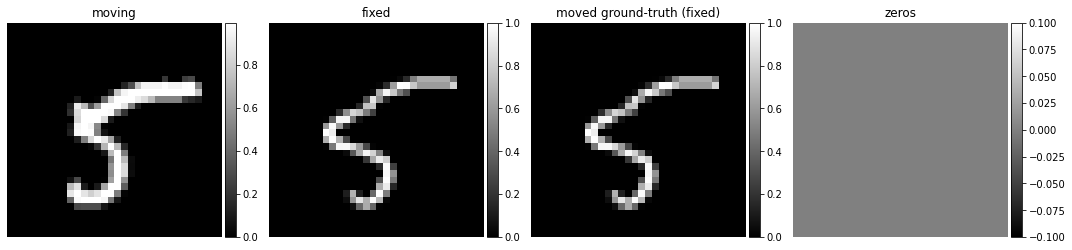

In [53]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [54]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ValueError: ignored

It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard. For this short tutorial, we will simply plot the loss.

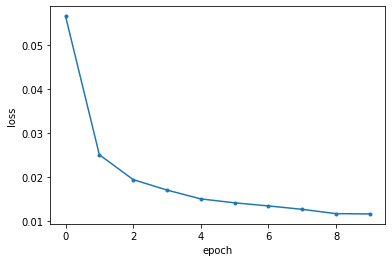

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

Clearly, this is not converged, and you should run it to convergence, but for the purposes of this tutorial, we'll move on.

# Registration

With pair-wise optimization methods (like most classical methods), to register a new pair you would need to optimize a deformation field.  

With learning based registration, we simply evaluate the network for a new input pair  

In [47]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

*Registration*: `predict()` essentially executes the network given an input.

In [48]:
val_pred = vxm_model.predict(val_input)

ValueError: ignored

and that's it! 

Even though this is on MNIST only, let's see how long this takes

In [50]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

ValueError: ignored

~3 ms per registration is quite fast, even for MNIST. Let's visualize the results.

In [49]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

NameError: ignored

Let's visualize the flow a bit better.

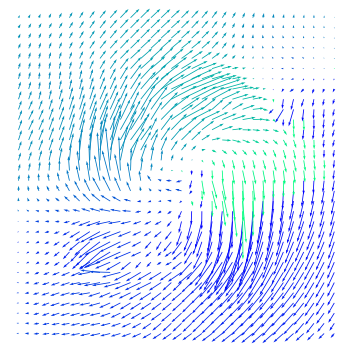

In [ ]:
ne.plot.flow([val_pred[1].squeeze()], width=5);

# Generalization 
How do learning-based methods generalize beyond training distribution ?

An important caveat to learning-based registration is that they will, in general, only register samples fromt he distribution they've been trained from.

So, what happens if we register two 7's?

In [ ]:
# extract only instances of the digit 7
x_sevens = x_train_load[y_train_load==7, ...].astype('float') / 255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

# predict
seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

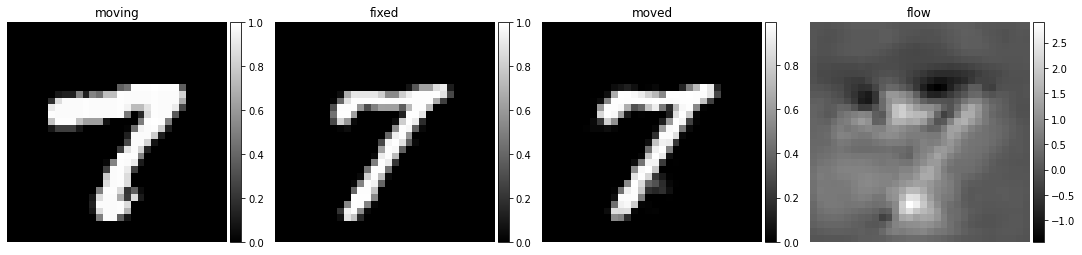

In [ ]:
# visualize
images = [img[0, :, :, 0] for img in seven_sample + seven_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Interesting - it still works! So it **generalized beyond what we expected**. Why? Locally, parts of the 7s look similar to the 5s, so the  registration algorithm still tries to match local neighborhoods.

Let's try a different variation. What if we just modify the (original) set, but multiplied the intensities by a factor?

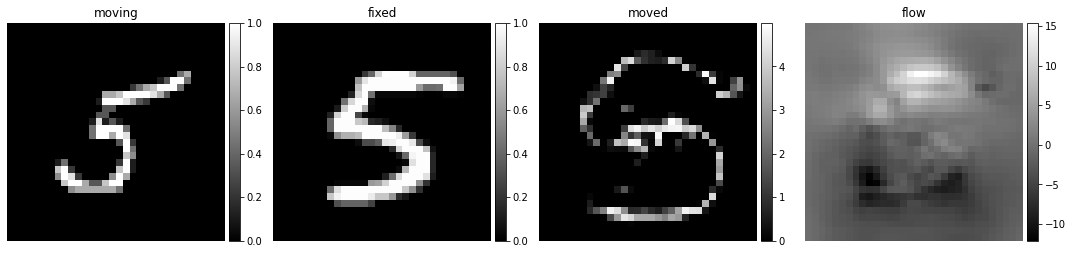

In [ ]:
factor = 5
val_pred = vxm_model.predict([f * factor for f in val_input])

# visualizeb
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

This broke down! Why? In this case, the network has never seen even parts of this image.

Understanding when the network generalizes and when it does not is very important, and still a part of active research.